<a href="https://colab.research.google.com/github/StellaHtet92/Geospatial/blob/main/Earthengine_TensorFlow_FCNN_demo_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook demonstrates how to develop a fully-convolutional model in TensorFlow and Keras, host the model on AI Platform and connect to the hosted model from Earth Engine.  Apache Beam is used to generate training data, so the first step is to install Beam and restart the runtime.

In [ ]:
!pip install apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.9 MB/s eta 0:00:00


## Imports

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

import ee
print('Using EE version ', ee.__version__)
import folium
print('Using Folium version ', folium.__version__)

from google.api_core import exceptions, retry
import google.auth
from google.colab import auth

import io
import matplotlib.pyplot as plt
import numpy as np

import random
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print('Using TF version ', tf.__version__)
from typing import Dict, Iterable, List, Tuple


Using EE version  0.1.323
Using Folium version  0.12.1.post1
Using TF version  2.8.2


## Authentication and initialization

See [the EE auth reference](https://developers.google.com/earth-engine/guides/auth) for more info.

In [ ]:
# Replace your-project with your project name.
PROJECT = 'your-project'

auth.authenticate_user()

credentials, _ = google.auth.default(
    scopes=[
        "https://www.googleapis.com/auth/cloud-platform",
        "https://www.googleapis.com/auth/earthengine",
    ]
)
ee.Initialize(
    credentials,
    project=PROJECT,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

## Variable declarations

In [ ]:
START = '2020-1-1'
END = '2021-1-1'

# A random spot near Ho Chi Minh, Vietnam.
COORDS = [105.695, 9.883]
PATCH_SIZE = 128  # Pixels
SCALE = 10        # Meters per pixel
VALIDATION_RATIO = 0.2
POINTS_PER_CLASS = 32
TEST_POINT = ee.Geometry.Point(COORDS)

# The TEST_ROI is precisely 16 times the size of an individual patch.
#  _ _ _ _ _ _ _ _
# |       |   |    |
# |       |_ _|_ _ |
# |       |   |    |
# |_ _ _ _._ _|_ _ |
# |       |        |
# |       |        |
# |       |        |
# |_ _ _ _|_ _ _ _ |

# Note that the edge of the region is 2 patches from the center. Therefore:
TEST_ROI = TEST_POINT.buffer(
    2 * PATCH_SIZE * SCALE, maxError=1).bounds(maxError=1)

# Hand draw a few polygons in the region of the TEST_ROI:
# https://code.earthengine.google.com/5a6833de86b6d5e9057ad2716f60cb76
geometry1 = ee.Geometry.Polygon(
    [[[106.48523200077895, 10.980975045790691],
      [106.48523200077895, 10.84140902509899],
      [106.69465888066176, 10.84140902509899],
      [106.69465888066176, 10.980975045790691]]], None, False)
geometry2 = ee.Geometry.Polygon(
    [[[106.78735602421645, 10.956707408297728],
      [106.78735602421645, 10.814432211409647],
      [107.01051581425551, 10.814432211409647],
      [107.01051581425551, 10.956707408297728]]], None, False)
geometry3 = ee.Geometry.Polygon(
    [[[106.22705328984145, 10.814432211409658],
      [106.22705328984145, 10.67748759749386],
      [106.40420783085708, 10.67748759749386],
      [106.40420783085708, 10.814432211409658]]], None, False)
geometry4 = ee.Geometry.Polygon(
    [[[106.72830451054458, 10.705826056410158],
      [106.72830451054458, 10.568157415555456],
      [106.92880499882583, 10.568157415555456],
      [106.92880499882583, 10.705826056410158]]], None, False)
geometry5 = ee.Geometry.Polygon(
    [[[106.48935187382583, 10.821176642541008],
      [106.48935187382583, 10.693006605173428],
      [106.70152533573989, 10.693006605173428],
      [106.70152533573989, 10.821176642541008]]], None, False)
geometry6 = ee.Geometry.Polygon(
    [[[106.47630560917739, 10.673439030314855],
      [106.47630560917739, 10.54250641226971],
      [106.67817938847426, 10.54250641226971],
      [106.67817938847426, 10.673439030314855]]], None, False)

# A list of regions from which to sample training data.
REGIONS = [geometry1, geometry2, geometry3, geometry4, geometry5, geometry6]

# Predictors.
INPUT_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
          'B8', 'B8A', 'B9', 'B11', 'B12']
# Target variable.
OUTPUT_BANDS = ['landcover']
# Input stack.
BANDS = INPUT_BANDS + OUTPUT_BANDS

COLUMNS = [
  tf.io.FixedLenFeature(shape=[PATCH_SIZE, PATCH_SIZE], dtype=tf.float32)
  for k in BANDS
]

FEATURES_DICT = dict(zip(BANDS, COLUMNS))

## Inspect datasets

### Classification system

In [ ]:
CLASSIFICATIONS = {
    "💧 Water":              "419BDF",
    "🌳 Trees":              "397D49",
    "🌾 Grass":              "88B053",
    "🌿 Flooded vegetation": "7A87C6",
    "🚜 Crops":              "E49635",
    "🪴 Shrub and scrub":    "DFC35A",
    "🏗️ Built-up areas":     "C4281B",
    "🪨 Bare ground":        "A59B8F",
    "❄️ Snow and ice":       "B39FE1",
}

def display_legend():
  reset_color = "\u001b[0m"
  colored = lambda red, green, blue: f"\033[48;2;{red};{green};{blue}m"
  for name, color in CLASSIFICATIONS.items():
    red   = int(color[0:2], 16)
    green = int(color[2:4], 16)
    blue  = int(color[4:6], 16)
    print(f"{colored(red, green, blue)}   {reset_color} {name}")

display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


### [Dynamic world](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1)

Just for comparison, load the Google Dynamic World land cover data and inspect.

In [ ]:
image = (
    ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
    .filterDate(START, END)
    .median()
)

vis_params = {
  'max': len(CLASSIFICATIONS) - 1,
  'palette': list(CLASSIFICATIONS.values()),
  'bands': ['label'],
}
folium.Map(
    location=(COORDS[1], COORDS[0]),
    zoom_start=10,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

### Sentinel-2 surface reflectance

We will use a cloud-freee composite of Sentinel-2 surface reflectance data for predictors.  See [the Code Editor example](https://code.earthengine.google.com/?scriptPath=Examples%3ACloud%20Masking%2FSentinel2%20Cloud%20And%20Shadow) for details.

In [ ]:
def get_s2_composite(roi, start, end):
  s2c = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
  s2sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
  s2c = s2c.filterBounds(roi.buffer(100*1000, 1000)).filterDate(start, end)
  s2sr = s2sr.filterBounds(roi.buffer(100*1000, 1000)).filterDate(start, end)

  def index_join(collection_a, collection_b, property_name):
    joined = ee.ImageCollection(
        ee.Join.saveFirst(property_name).apply(
            primary=collection_a,
            secondary=collection_b,
            condition=ee.Filter.equals(
                leftField='system:index',
                rightField='system:index')))
    return joined.map(
        lambda image: image.addBands(ee.Image(image.get(property_name))))

  def mask_image(image):
    prob = image.select('probability')
    return image.select('B.*').divide(10000).updateMask(prob.lt(50))

  with_cloud_probability = index_join(s2sr, s2c, 'cloud_probability')
  masked = ee.ImageCollection(with_cloud_probability.map(mask_image))
  return masked.select(INPUT_BANDS).median().float().unmask(0)

image = get_s2_composite(TEST_POINT, START, END)

vis_params = {
  'min': 0,
  'max': 0.4,
  'bands': ['B4', 'B3', 'B2'],
}

folium.Map(
    location=(COORDS[1], COORDS[0]),
    zoom_start=10,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

### [ESA WorldCover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100)

We'll use labels from WorldCover as the target variable.

In [ ]:
def landcover_image() -> ee.Image:
    # Remap the ESA classifications into the Dynamic World classifications
    fromValues = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
    toValues = [1, 5, 2, 4, 6, 7, 8, 0, 3, 3, 7]
    return (
        ee.ImageCollection('ESA/WorldCover/v100')
        .first()
        .select('Map')
        .remap(fromValues, toValues)
        .rename(OUTPUT_BANDS)
    )

image = landcover_image()

vis_params = {
  'bands': OUTPUT_BANDS,
  'palette': list(CLASSIFICATIONS.values()),
}

folium.Map(
    location=(COORDS[1], COORDS[0]),
    zoom_start=10,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

In [ ]:
display_legend()

    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


## Generate training data

There are a number of ways to generate training data in Earth Engine.  This notebook demonstrates using `getDownloadUrl()` in a Beam pipeline to generate training data.  The following methods take a random sample of points in an area of interest and get a patch of training data centered on each point.

In [ ]:
def sample_random_points(region: ee.Geometry, points_per_class: int) -> Iterable[List]:
  """Get a generator of random points in the region."""
  image = landcover_image().select(OUTPUT_BANDS).int()
  points = image.stratifiedSample(
      POINTS_PER_CLASS,
      region=region,
      scale=SCALE,
      geometries=True,
  )
  for point in points.toList(points.size()).getInfo():
      yield point['geometry']['coordinates']


@retry.Retry()
def get_patch(image: ee.Image, region: ee.Geometry, bands: List[str], patch_size: int) -> np.ndarray:
  """Get the patch of pixels in the geometry as a Numpy array."""
  # Create the URL to download the band values of the patch of pixels.
  url = image.getDownloadURL({
      'region': region,
      'dimensions': [patch_size, patch_size],
      'format': "NPY",
      'bands': bands,
  })

  # Download the pixel data. If we get "429: Too Many Requests" errors,
  # it's safe to retry the request.
  response = requests.get(url)
  if response.status_code == 429:
    # The retry.Retry library only works with `google.api_core` exceptions.
    raise exceptions.TooManyRequests(response.text)
    # Still raise any other exceptions to make sure we got valid data.
  response.raise_for_status()

  # Load the NumPy file data and return it as a NumPy array.
  return np.load(io.BytesIO(response.content), allow_pickle=True)


def get_training_patch(
    coords: List[float], bands: List[str] = [],
    patch_size: int = 128, scale: int = 10) -> np.ndarray:
  """Get a training patch centered on the coordinates."""
  point = ee.Geometry.Point(coords)
  region = point.buffer(scale * patch_size / 2, 1).bounds(1)
  image = get_s2_composite(point, START, END).addBands(landcover_image())
  return get_patch(image, region, bands, patch_size)

Check the training data creation on a test area.  Here we just print coordinates of all the points and get a test patch from one of them.

In [ ]:
sample = sample_random_points(TEST_ROI, POINTS_PER_REGION)
for coords in sample:
  print(f"coords: {coords}")

patch = get_training_patch(coords, BANDS, patch_size=PATCH_SIZE, scale=SCALE)
print(f"patch shape={patch.shape} bands={len(patch.dtype)}")
print(f"dtype: {patch.dtype}")

coords: [105.68259566375448, 9.877897047512835]
coords: [105.71693302681908, 9.90295166376565]
coords: [105.70889881485783, 9.879222997858392]
coords: [105.67285510395556, 9.864390687774566]
coords: [105.68952633675448, 9.902191560311097]
coords: [105.7101520482972, 9.905666759071082]
coords: [105.67779233810779, 9.89094702947714]
coords: [105.67192219698161, 9.900840703961867]
coords: [105.68298251061417, 9.865192360678183]
coords: [105.67387297988877, 9.889248123457769]
coords: [105.68222794622793, 9.878574989451812]
coords: [105.68937358272669, 9.892213644496003]
coords: [105.69481873875027, 9.883011634622996]
coords: [105.67819424832847, 9.902500785829691]
coords: [105.71743652935346, 9.87399704645555]
coords: [105.67206296773197, 9.866117181584455]
coords: [105.69097526924348, 9.899492367586813]
coords: [105.67608891230002, 9.905795326489509]
coords: [105.71464273207913, 9.863554993834368]
coords: [105.70788436892163, 9.872447241981112]
coords: [105.70322162417851, 9.8940965710185

Render the test patch to check the predictors and land cover target variable.

sentinel2_rgb: uint8 (128, 128, 3)


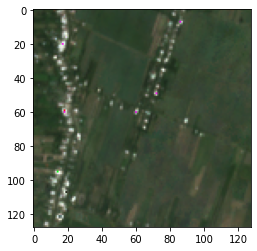

In [ ]:
def render_rgb_images(values: np.ndarray, min=0.0, max=1.0) -> np.ndarray:
  scaled_values = (values - min) / (max - min)
  rgb_values = scaled_values * 255
  return rgb_values.astype(np.uint8)

def render_sentinel2(patch: np.ndarray, min=0.0, max=0.3) -> np.ndarray:
  red   = patch["B4"]
  green = patch["B3"]
  blue  = patch["B2"]
  rgb_patch = np.stack([red, green, blue], axis=-1)
  return render_rgb_images(rgb_patch, min, max)

sentinel2_rgb = render_sentinel2(patch)

print(f"sentinel2_rgb: {sentinel2_rgb.dtype} {sentinel2_rgb.shape}")
plt.imshow(sentinel2_rgb)

landcover_rgb: uint8 (128, 128, 3)
    💧 Water
    🌳 Trees
    🌾 Grass
    🌿 Flooded vegetation
    🚜 Crops
    🪴 Shrub and scrub
    🏗️ Built-up areas
    🪨 Bare ground
    ❄️ Snow and ice


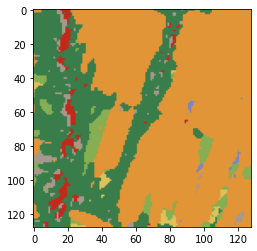

In [ ]:
def render_classifications(values: np.ndarray, palette: List[str]) -> np.ndarray:
  # Create a color map from a hex color palette.
  xs = np.linspace(0, len(palette), 256)
  indices = np.arange(len(palette))
  color_map = np.array([
        np.interp(xs, indices, [int(c[0:2], 16) for c in palette]),  # red
        np.interp(xs, indices, [int(c[2:4], 16) for c in palette]),  # green
        np.interp(xs, indices, [int(c[4:6], 16) for c in palette]),  # blue
  ]).astype(np.uint8).transpose()

  color_indices = (values / len(palette) * 255).astype(np.uint8)
  return np.take(color_map, color_indices, axis=0)

def render_landcover(patch: np.ndarray) -> np.ndarray:
  return render_classifications(patch, list(CLASSIFICATIONS.values()))

landcover_rgb = render_landcover(patch["landcover"])

print(f"landcover_rgb: {landcover_rgb.dtype} {landcover_rgb.shape}")
plt.imshow(landcover_rgb)
display_legend()

This function serializes a patch of data into a `tf.train.Example` proto.

In [ ]:
def serialize(patch: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            float_list=tf.train.FloatList(value=patch[name].flatten())
        )
        for name in patch.dtype.names
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

serialized = serialize(patch)
print(f"serialized: {type(serialized).__name__} ({len(serialized)})")

serialized: bytes (852242)


### Option 1: Write data

Delete any data that may have previously been created.  You may also skip ahead and copy pre-generated training.

In [ ]:
!rm datasets/*

rm: cannot remove 'datasets/*': No such file or directory


Create the Beam pipeline.  This will create random sample points from a set of predefined regions, sample patches at the points, serialize the patches, split into training and validation sets, and write the data as TFRecords.

In [ ]:
def split_dataset(element, num_partitions: int) -> int:
  weights = [1 - VALIDATION_RATIO, VALIDATION_RATIO]
  return random.choices([0, 1], weights)[0]

beam_options = PipelineOptions([], direct_num_workers=len(REGIONS))

with beam.Pipeline(options=beam_options) as pipeline:
  training_data, validation_data = (
      pipeline
      | "Create regions" >> beam.Create(REGIONS)
      | "Sample random points" >> beam.FlatMap(sample_random_points, POINTS_PER_REGION)
      | "Get patch" >> beam.Map(get_training_patch, BANDS, PATCH_SIZE)
      | "Serialize" >> beam.Map(serialize)
      | "Split dataset" >> beam.Partition(split_dataset, 2)
  )

  training_data | "Write training data" >> beam.io.WriteToTFRecord(
      "datasets/training", file_name_suffix=".tfrecord.gz"
  )
  validation_data | "Write validation data" >> beam.io.WriteToTFRecord(
      "datasets/validation", file_name_suffix=".tfrecord.gz"
  )

You can **safely ignore** the _"Connection pool is full"_ **warnings**.
Rest assured that [no data is lost](https://stackoverflow.com/a/53765527/11638084).

List the datasets to verify that the files were written.

### Option 2: load pre-baked datasets

In [ ]:
!mkdir datasets
!gsutil cp gs://ee-docs-demos/g4g-tf-demos/tiles_2022/*.gz datasets/.

mkdir: cannot create directory ‘datasets’: File exists
Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/training-00000-of-00006.tfrecord.gz...
Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/training-00001-of-00006.tfrecord.gz...
Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/training-00002-of-00006.tfrecord.gz...
Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/training-00003-of-00006.tfrecord.gz...
| [4 files][149.1 MiB/149.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/training-00004-of-00006.tfrecord.gz...
Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/training-00005-of-00006.tfrecord.gz...
Copying gs://ee-docs-demos/g4g-tf-demos/tiles_2022/validation-00000-of-0

In [ ]:
!ls -lh datasets/*.tfrecord.gz

-rw-r--r-- 1 root root  37M Sep 28 22:09 datasets/training-00000-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  42M Sep 28 22:09 datasets/training-00001-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  40M Sep 28 22:09 datasets/training-00002-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  32M Sep 28 22:09 datasets/training-00003-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  37M Sep 28 22:09 datasets/training-00004-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  42M Sep 28 22:09 datasets/training-00005-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  12M Sep 28 22:09 datasets/validation-00000-of-00006.tfrecord.gz
-rw-r--r-- 1 root root 7.5M Sep 28 22:09 datasets/validation-00001-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  12M Sep 28 22:09 datasets/validation-00002-of-00006.tfrecord.gz
-rw-r--r-- 1 root root 8.9M Sep 28 22:09 datasets/validation-00003-of-00006.tfrecord.gz
-rw-r--r-- 1 root root 8.6M Sep 28 22:09 datasets/validation-00004-of-00006.tfrecord.gz
-rw-r--r-- 1 root root  11M Sep 28 22:09 dat

## Data reading and parsing functions

Define some functions to read and parse datasets.  In addition, randomly flip the input patches to augment the data set.  See [this reference](https://www.tensorflow.org/tutorials/images/data_augmentation) for details on data augmentation.  See [this reference](https://www.tensorflow.org/guide/data_performance#best_practice_summary) for details on loading datasets efficiently.  Read the datasets and print a single example to check.

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(
        mode="horizontal_and_vertical", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(
        mode="horizontal_and_vertical", seed=seed)

  def call(self, inputs, labels):
    inputs = {name: self.augment_inputs(v) for name, v in inputs.items()}
    labels = self.augment_labels(labels)
    return inputs, labels


def parse_tfrecord(example_proto):
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  return (
      {name: inputs[name] for name in INPUT_BANDS},
      tf.one_hot(tf.cast(inputs[OUTPUT_BANDS[0]], tf.uint8), len(CLASSIFICATIONS))
  )


def get_dataset(pattern, batch_size):
  dataset = tf.data.Dataset.list_files(pattern).interleave(
      lambda filename: tf.data.TFRecordDataset(filename, compression_type='GZIP'))
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.map(to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.cache()
  dataset = dataset.shuffle(512)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


# Create the training and validation datasets.
training_dataset = get_dataset('datasets/training*.tfrecord.gz', 4).map(
    Augment(), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = get_dataset('datasets/validation*.tfrecord.gz', 1)

# Inspect the first element from the training dataset.
for inputs, outputs in training_dataset.take(1):
  print("inputs:")
  for name, values in inputs.items():
    print(f"  {name}: {values.dtype.name} {values.shape}")
  print(f"outputs: {outputs.dtype.name} {outputs.shape}")

inputs:
  B1: float32 (4, 128, 128)
  B2: float32 (4, 128, 128)
  B3: float32 (4, 128, 128)
  B4: float32 (4, 128, 128)
  B5: float32 (4, 128, 128)
  B6: float32 (4, 128, 128)
  B7: float32 (4, 128, 128)
  B8: float32 (4, 128, 128)
  B8A: float32 (4, 128, 128)
  B9: float32 (4, 128, 128)
  B11: float32 (4, 128, 128)
  B12: float32 (4, 128, 128)
outputs: float32 (4, 128, 128, 9)


## Define the model

This is a relatively simple model based on [this example](https://keras.io/examples/vision/oxford_pets_image_segmentation/).  The model is modified from the example to use fewer filters, and therfore to have fewer parameters.  This is only for demonstration purposes.

In [ ]:
def get_model(input_shape, num_classes):
    inputs = keras.Input(shape=[None, None, len(INPUT_BANDS)])

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

Print a summary of the model.

In [ ]:
model = get_model([PATCH_SIZE, PATCH_SIZE, len(INPUT_BANDS)], len(CLASSIFICATIONS))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 12)]                                                             
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   3488        ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_11 (BatchN  (None, None, None,   128        ['conv2d_7[0][0]']               
 ormalization)                  32)                                                         

Inspect a batch or inputs and outputs.  Note that you get a tuple of `(inputs, labels)`, where the `inputs` is a dictionary of patches, keyed by band name.  Note that the shape of each patch is `[batch, height, width]`.

In [ ]:
inputs, labels = iter(training_dataset.take(1)).next()

print(inputs)
print(labels)

{'B1': <tf.Tensor: shape=(4, 128, 128), dtype=float32, numpy=
array([[[0.049     , 0.05035   , 0.049     , ..., 0.0795    ,
         0.0795    , 0.0795    ],
        [0.05035   , 0.05035   , 0.05      , ..., 0.076     ,
         0.076     , 0.076     ],
        [0.05135   , 0.05035   , 0.05      , ..., 0.076     ,
         0.076     , 0.076     ],
        ...,
        [0.0711    , 0.0701    , 0.0702    , ..., 0.06225   ,
         0.0644    , 0.0644    ],
        [0.0701    , 0.0701    , 0.0702    , ..., 0.0644    ,
         0.0644    , 0.0644    ],
        [0.0704    , 0.0704    , 0.0688    , ..., 0.0644    ,
         0.066     , 0.0644    ]],

       [[0.142     , 0.1426    , 0.13445   , ..., 0.0749    ,
         0.0749    , 0.073     ],
        [0.1405    , 0.13875   , 0.1346    , ..., 0.078     ,
         0.0777    , 0.0716    ],
        [0.1405    , 0.1404    , 0.13385   , ..., 0.0777    ,
         0.0774    , 0.0777    ],
        ...,
        [0.1827    , 0.1907    , 0.2224    , .

Wrap the model in a concatenation layer.  This layer stacks the inputs into a `[height, width, channels]` shaped cube, which is then input to the model.

In [ ]:
# Define the input dictionary layers.
inputs_dict = {
    name: tf.keras.Input(shape=(None, None, 1), name=name)
    for name in INPUT_BANDS
}

concat = tf.keras.layers.Concatenate()(inputs_dict.values())
new_model = tf.keras.Model(inputs=inputs_dict, outputs=model(concat))
# print(new_model(inputs))

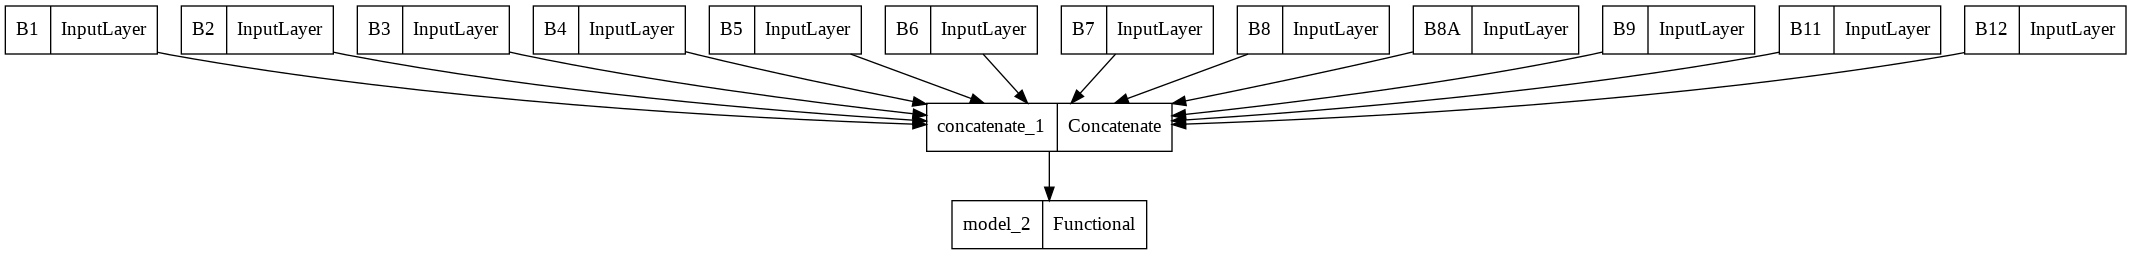

In [ ]:
tf.keras.utils.plot_model(new_model)

## Train the model

In [ ]:
new_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.OneHotIoU(
            num_classes=len(CLASSIFICATIONS),
            target_class_ids=list(range(len(CLASSIFICATIONS))),
        ),
        tf.keras.metrics.Accuracy(),
    ]
)

new_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=13,
)

Epoch 1/13
153/153 [==============================] - 114s 707ms/step - loss: 1.5639 - one_hot_io_u_1: 0.2254 - accuracy: 1.7199e-05 - val_loss: 2.1309 - val_one_hot_io_u_1: 0.0256 - val_accuracy: 0.0000e+00
Epoch 2/13
153/153 [==============================] - 100s 650ms/step - loss: 1.2086 - one_hot_io_u_1: 0.2952 - accuracy: 0.0000e+00 - val_loss: 2.1254 - val_one_hot_io_u_1: 0.0250 - val_accuracy: 0.0000e+00
Epoch 3/13
153/153 [==============================] - 101s 660ms/step - loss: 1.1644 - one_hot_io_u_1: 0.2996 - accuracy: 0.0000e+00 - val_loss: 1.8659 - val_one_hot_io_u_1: 0.0836 - val_accuracy: 0.0000e+00
Epoch 4/13
153/153 [==============================] - 104s 682ms/step - loss: 1.1306 - one_hot_io_u_1: 0.3173 - accuracy: 0.0000e+00 - val_loss: 1.1258 - val_one_hot_io_u_1: 0.3443 - val_accuracy: 0.0000e+00
Epoch 5/13
153/153 [==============================] - 97s 635ms/step - loss: 1.0720 - one_hot_io_u_1: 0.3303 - accuracy: 0.0000e+00 - val_loss: 1.2943 - val_one_hot_io_

## de/serialization

This should really be called *AIPlatformification* but that's too long so we call it *EEification*.  AI Platform online prediction expects `base64` encoded inputs and returns `base64` encoded outputs.  In order to get predictions, the data must be serialized in this format before sending it to AI Platform and the output from AI Platform needs to be deserialized.  Here we add layers to the model to perform that prgramatically.  The command line [`earthengine model prepare`](https://developers.google.com/earth-engine/guides/command_line#model) does the same thing.

In [ ]:
class DeserlializeInput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, tensor):
    return_dict={}

    for (k, v) in tensor.items():
      decoded = tf.io.decode_base64(v)
      return_dict[k] = tf.map_fn(lambda x: tf.io.parse_tensor(x, tf.float32), decoded, dtype=tf.float32)

    return return_dict

  def get_config(self):
    config = super().get_config()
    return config


class ReserlializeOutput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, tensor_input):
    return tf.map_fn(lambda x: tf.io.encode_base64(tf.io.serialize_tensor(x)), tensor_input, dtype=tf.string)

  def get_config(self):
    config = super().get_config()
    return config


input_deserializer = DeserlializeInput()
output_deserilaizer = ReserlializeOutput()

serlialized_inputs = {
    b: tf.keras.Input(shape=[], dtype='string', name=b) for b in INPUT_BANDS}

updated_model_input = input_deserializer(serlialized_inputs)
updated_model = new_model(updated_model_input)
updated_model = output_deserilaizer(updated_model)
updated_model= tf.keras.Model(serlialized_inputs, updated_model)

Instructions for updating:
Use fn_output_signature instead


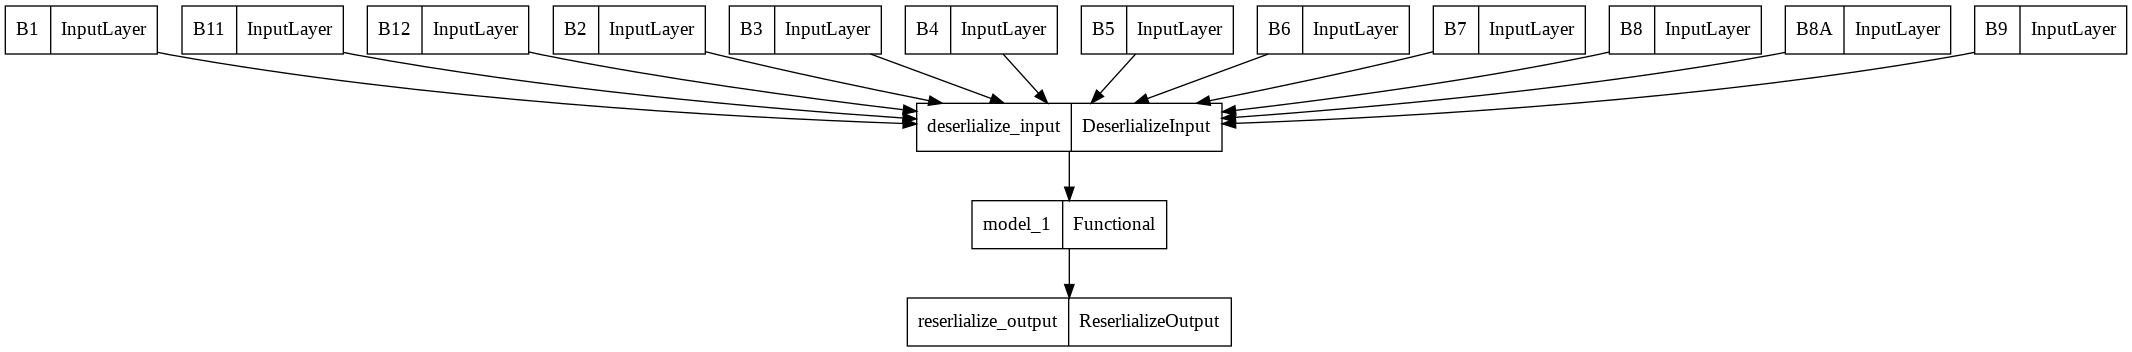

In [ ]:
tf.keras.utils.plot_model(updated_model)

## Save the trained model

In [ ]:
MODEL_NAME = 'fcnn_demo_2022'
# Replace your-bucket with your bucket name.
MODEL_DIR = 'gs://your-bucket/' + MODEL_NAME
updated_model.save(MODEL_DIR)

## Host the trained model on Cloud AI Platform

Create a model then create a version of the model that points to the directory with the saved model.

Start a new default instance from the model.  Works:
https://code.earthengine.google.com/0f55beb69d4c99808e9b74d3e16275bc

In [ ]:
REGION = 'us-central1'
VERSION_NAME = 'v0_demo'

!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {MODEL_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.8 \
  --python-version=3.7

Using endpoint [https://us-central1-ml.googleapis.com/]


## Connect to the hosted model from Earth Engine

In [ ]:
model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    proj=ee.Projection('EPSG:4326').atScale(10),
    inputTileSize=[64, 64],
    inputOverlapSize=[32, 32],
    fixInputProj=True,
    outputBands={
      'array': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    }
)

composite = get_s2_composite(TEST_POINT, START, END)
predictions = model.predictImage(composite.select(INPUT_BANDS))
print('scale of output', predictions.projection().nominalScale().getInfo())
labels = predictions.arrayArgmax().arrayGet(0).byte().rename('label')

scale of output 10


In [ ]:
vis_params = {
  'min': 0,
  'max': len(CLASSIFICATIONS) - 1,
  'palette': list(CLASSIFICATIONS.values()),
  'bands': ['label'],
}

folium.Map(
    location=(COORDS[1], COORDS[0]),
    zoom_start=13,
    tiles=labels.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## Clean up

To avoid incurring costs, delete all buckets, versions and models created through this tutorial.